In [1]:
# Task B. Run a logistic regression with Engagement (binary) as the dependent variable, and the 
# image labels (text) as independent variables. What is the accuracy (show the confusion matrix)?

In [7]:
import json
import warnings
import numpy
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_predict, cross_val_score


nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')


warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data Preperation

##### Reading the data

In [34]:
df = pd.read_csv('img_lbs_scr_with_engagement.csv') \
       .drop(['Unnamed: 0'], axis=1)

df['imgUrl'] = df['imgUrl'].apply(lambda x: x.split('media')[0])
print(df.columns)
print(df.shape)


df2 = pd.DataFrame(columns=['img_url', 'description'])
# Opening JSON file
f = open('insta_post1.json')  
# returns JSON object as  a dictionary
data = json.load(f)
# Iterating through the json list
for descr in data:
    df2 = df2.append({'img_url': descr['postUrl'], 'description': descr['description'] }, ignore_index=True)
f.close()

print(df.shape, df2.shape)

descr_lookup = df2.set_index('img_url').to_dict()['description']
df['description'] = df.apply(lambda row: descr_lookup[row['imgUrl']], axis=1)

Index(['imgUrl', 'labels', 'score', 'likeCount', 'commentCount', 'caption',
       'normalizedLikeCount', 'normalizedCommentCount', 'engagementScore',
       'engagement'],
      dtype='object')
(893, 10)
(893, 10) (893, 2)


In [28]:
# df = df.drop_duplicates(subset=['imgUrl', 'description', 'engagement', 'labels']) \
#        .filter(['description', 'engagement', 'labels'])

In [35]:
df.isnull().sum()

imgUrl                      0
labels                      0
score                       0
likeCount                   0
commentCount                0
caption                   542
normalizedLikeCount         0
normalizedCommentCount      0
engagementScore             0
engagement                  0
description                 0
dtype: int64

##### Processing the data

In [36]:
stemmer = SnowballStemmer("english")
stop = stopwords.words('english')

def remove_punctuation(s):
    """
    function to remove punctuations in a 
    sentence
    """
    string_punctuation = '''()-[]{};:'"\,<>./?@#$%^&*_~1234567890'''
    no_punct = ""
    for letter in s:
        if letter not in string_punctuation:
            no_punct += letter
    return no_punct

# Define function to lemmatize each word with its POS tag

# POS_TAGGER_FUNCTION : TYPE 1
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
    
def lemmetization(pos_tagged_words):
    lemmatized_sentence = []
    for word, tag in pos_tagged_words:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence

    
print(df.shape)    
    
# removing unnecessary characters
df['description'] = df['description'].apply(lambda x: x.lower().split('|')[-1] \
                                                       .replace('\n', '') \
                                                       .replace('“', '') \
                                                       .replace('”', ''))
# removing punctuations in a sentence
i = 0
for row in df['description']:
    df.iloc[ i, -1] = remove_punctuation(row)
    i=i+1
    
df['description'] = df['description'].apply(word_tokenize)
df['description'] = df['description'].apply(lambda x : [w for w in x if w not in stop])

# df['description'] = df['description'].apply(lambda x: [stemmer.stem(y) for y in x])
# df['description'] = df['description'].apply(lambda x : " ".join(x))

lemmatizer = WordNetLemmatizer()
df['description'] = df['description'].apply(lambda x: nltk.pos_tag(x))
df['description'] = df['description'].apply(lambda words: list(map(lambda x: (x[0], pos_tagger(x[1])), words)))
df['description'] = df['description'].apply(lambda pos_tagged_words: lemmetization(pos_tagged_words))


Text_Column = list(df['description'].copy())
sklearn_tfidf = TfidfVectorizer(min_df=.01, max_df =.95, stop_words="english",use_idf=True, smooth_idf=False, sublinear_tf=True)
sklearn_representation = sklearn_tfidf.fit_transform(Text_Column)
Tfidf_Output = pd.DataFrame(sklearn_representation.toarray(), columns=sklearn_tfidf.get_feature_names())

(893, 11)


In [39]:
final_data = pd.concat([Tfidf_Output, df['engagement']], axis=1)
final_data.drop_duplicates(inplace=True)
print(final_data.shape)

(485, 1387)


#### Modeling

In [40]:
#Plotting Confusion Matrix
def show_confusion_matrix(C,class_labels=['0','1']):

    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."

    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            '%d'%(tn),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            '%d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            '%d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            '%d'%(tp),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'Error: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'Error: %.2f'%(fn / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,' ',
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            ' ',
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()

CV  accuracy 0.6742268041237114
CV auc score 0.743199956578376


C:\Users\shiva\AppData\Local\Temp\ipykernel_14684\4126636653.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(class_labels + [''],rotation=90)


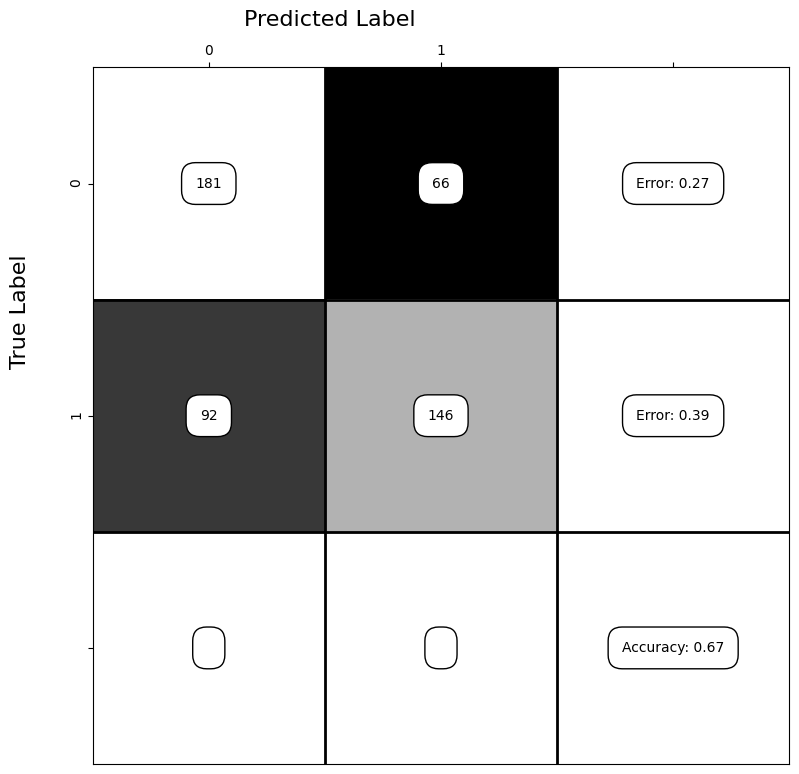

<Figure size 640x480 with 0 Axes>

In [41]:
selected_features = [col for col in final_data.columns if col not in ['engagement']]
X = final_data[selected_features]
Y = final_data['engagement']

#Logit Regression
classifier = LogisticRegression()
Y_pred = model_selection.cross_val_predict(classifier, X, Y, cv=5)

# calculating CV accuracy
cv_scores = cross_val_score(classifier, X, Y, cv=5)
print("CV  accuracy", sum(cv_scores) / len(cv_scores))

# calculating CV roc_roc
cv_scores = cross_val_score(classifier, X, Y, cv=5, scoring='roc_auc')
print("CV auc score", sum(cv_scores) / len(cv_scores))

# calculating confusion matrix
cm = confusion_matrix(Y, Y_pred)
show_confusion_matrix(cm, ['0', '1'])
plt.show()
plt.savefig('Confusion.png')

In [42]:
final_data.to_csv('data_for_caption_logit.csv')